In [1]:
# SH-I

In [2]:
from glynet import *

In [3]:
# class GlyNet(nn.Module):
    
#     def __init__(self):
#         super(GlyNet, self).__init__()
#         self.fc1 = nn.Linear(1040, 800)
#         self.fc2 = nn.Linear(800, 800)
#         self.fc3 = nn.Linear(800, 50)
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [4]:
data = get_data(transformation = np.cbrt, cutoff = 1.0)
data.head()

,IUPAC,AAA,AAL,ABA,ACL,AIA,AMA,AOL,BPL,CAA,...,SNA,STA,TJA,TL,UDA,UEA,VGA,VVL,WFL,WGA
0,Gal(a1-Sp8,4.372858,4.167230,11.961571,2.139711,21.991218,4.239280,4.283983,2.239729,3.885891,...,4.997460,4.207602,3.703668,1.000000,2.142846,1.0,4.903597,4.222035,2.376969,7.461575
1,Glc(a1-Sp8,5.920529,3.816098,12.437614,2.167011,1.000000,3.767102,4.050202,2.292355,3.085994,...,6.461637,3.116482,5.832524,1.000000,2.746133,1.0,5.367763,3.315473,1.980999,7.520612
2,Man(a1-Sp8,4.391430,2.661648,9.542767,2.169314,1.000000,4.571336,4.120613,3.204097,2.252729,...,6.279191,3.448673,4.214564,2.550254,2.670529,1.0,3.471939,3.379915,2.692877,6.133126
3,GalNAc(a1-Sp8,4.667372,2.100263,5.055442,13.607672,31.486598,1.858734,2.866164,23.956914,1.820443,...,3.597608,2.372793,3.050818,1.150529,1.741230,1.0,3.958229,33.314936,30.684647,24.644268
4,GalNAc(a1-Sp15,3.762482,3.430544,3.388678,2.124570,19.338650,3.519719,3.630171,8.424235,3.442724,...,1.000000,2.141957,3.097587,1.433175,2.742227,1.0,4.691258,30.653437,26.789213,5.192208


In [5]:
epochs = 250 # [250, 500, 750, 1000]
lr = 0.01 # [0.005, 0.01, 0.05]
batch_size = 16

In [6]:
def train(epochs, lr, batch_size, n_hidden, size):
    """Train for one full cycle."""
    class GlyNet(nn.Module):
        def __init__(self):
            super(GlyNet, self).__init__()
            self.fc1 = nn.Linear(1040, n_hidden)
            self.fc2 = nn.Linear(n_hidden, n_hidden)
            self.fc3 = nn.Linear(n_hidden, n_hidden)
            self.fc4 = nn.Linear(n_hidden, n_hidden)
            self.fc5 = nn.Linear(n_hidden, 50)
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = F.relu(self.fc4(x))
            x = F.relu(self.fc5(x))
            return x
    proteins = list(data.columns[1:])
    traindata = list(zip(data['IUPAC'], data[proteins].values.tolist()))
    glycans, actual, predicted = [], [], []
    for i, (held_out, kept_in) in enumerate(ten_fold(traindata)):
        train_losses, test_losses, r2s = [], [], []
        trainloader = prepare_data(kept_in, mode = 'train')
        print('fold', i + 1, 'held out')
        net = GlyNet()
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr = lr)
        for epoch in range(epochs):
            train_loss = 0.0
            for inputs, values in trainloader:
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(values, outputs)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            test_inputs, test_values = prepare_data(held_out, mode = 'test')
            with torch.no_grad():
                test_outputs = net(test_inputs)
                test_loss = criterion(test_values, test_outputs).item()
                r2 = r2_score(test_values, test_outputs)
            train_losses.append(train_loss / (600 / batch_size))
            test_losses.append(test_loss)
            r2s.append(r2)
        glycans += [glycans for glycans, actual in held_out]
        actual += [actual for glycans, actual in held_out]
        predicted += test_outputs.squeeze(1).tolist()
        print('train_loss:', round(train_loss / (600 / batch_size), 4))
        print('test_loss:', round(test_loss, 4))
        print('r-squared:', round(r2, 4))
        plot_performance(train_losses, test_losses, r2s)
    print('finished training.', '\n')
    path = './results/'
#     experiment = 'glynet50_lr' + str(lr) + '_epochs' + str(epochs) +'_bs' + str(batch_size)
    experiment = 'glynet50_nh' + str(n_hidden) + '_size' + str(size)
    results = make_results(data, actual, predicted, glycans, experiment, path, proteins, save = True)
    plot_all(results, experiment, proteins, filename = path + experiment + '.pdf')

n_hidden: 200 size: 4 

fold 1 held out
train_loss: 6.1693
test_loss: 24.7626
r-squared: 0.4223


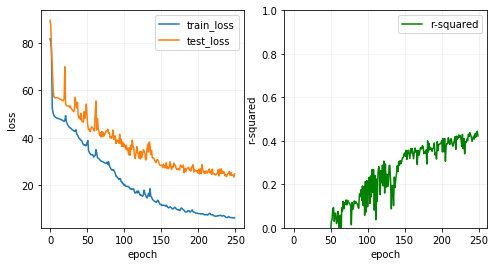

fold 2 held out
train_loss: 6.9604
test_loss: 29.5959
r-squared: 0.4083


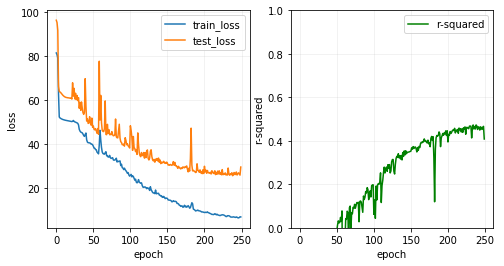

fold 3 held out
train_loss: 6.5629
test_loss: 23.3039
r-squared: 0.4956


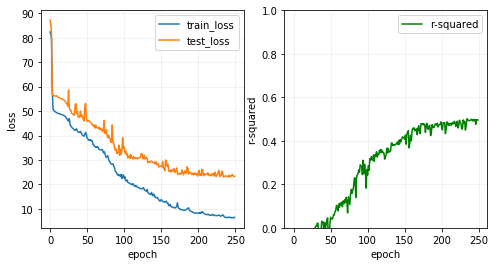

fold 4 held out
train_loss: 6.4966
test_loss: 24.8936
r-squared: 0.2604


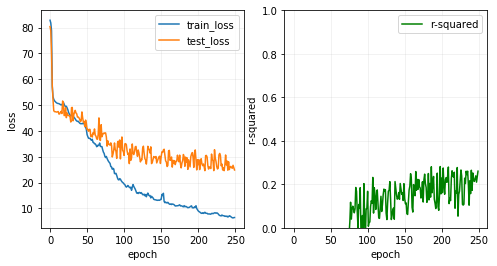

fold 5 held out
train_loss: 6.6844
test_loss: 22.7236
r-squared: 0.371


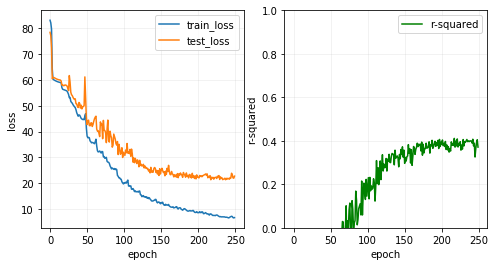

fold 6 held out
train_loss: 6.2484
test_loss: 22.1613
r-squared: 0.4792


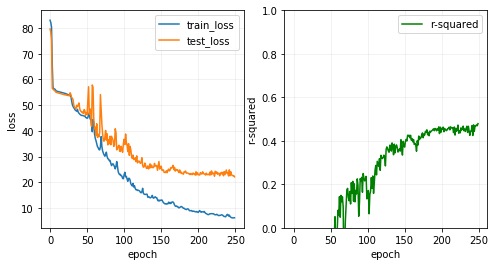

fold 7 held out
train_loss: 6.0841
test_loss: 25.3931
r-squared: 0.4443


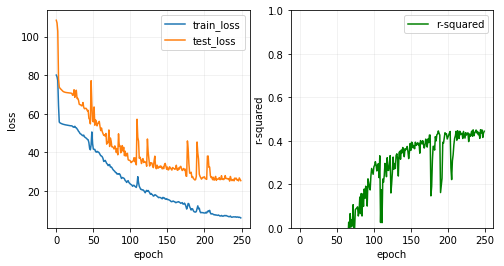

fold 8 held out
train_loss: 7.2274
test_loss: 23.5538
r-squared: 0.4072


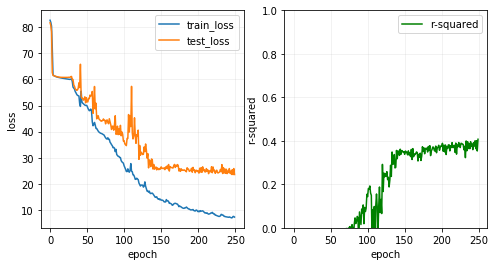

fold 9 held out
train_loss: 6.159
test_loss: 30.2852
r-squared: 0.4425


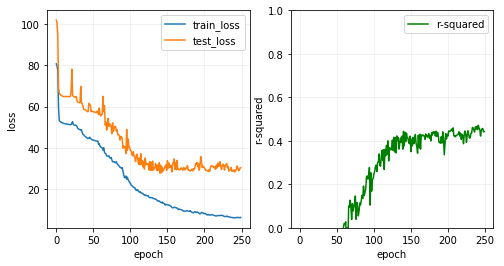

fold 10 held out
train_loss: 5.9426
test_loss: 30.0325
r-squared: 0.402


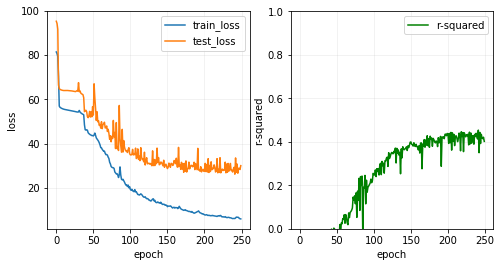

finished training. 

n_hidden: 400 size: 4 

fold 1 held out
train_loss: 5.8176
test_loss: 25.3818
r-squared: 0.4181


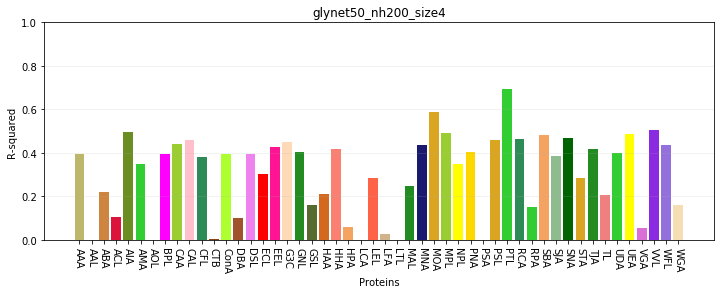

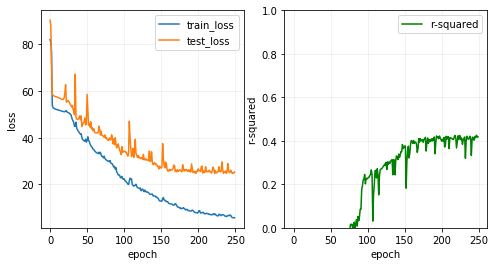

fold 2 held out
train_loss: 5.888
test_loss: 23.1041
r-squared: 0.384


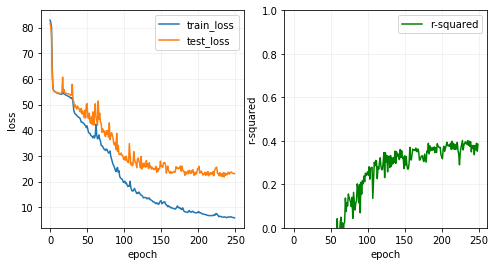

fold 3 held out
train_loss: 6.6174
test_loss: 22.6316
r-squared: 0.4099


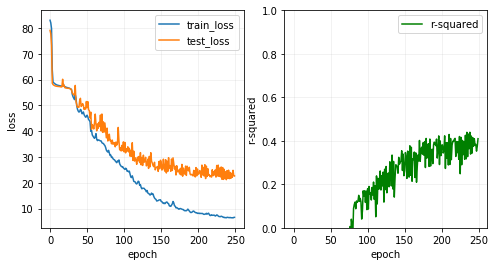

fold 4 held out
train_loss: 5.2806
test_loss: 31.4095
r-squared: 0.3211


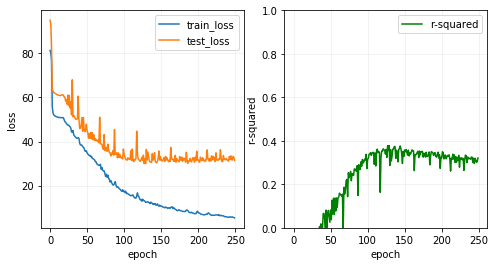

fold 5 held out
train_loss: 5.7507
test_loss: 27.44
r-squared: 0.4047


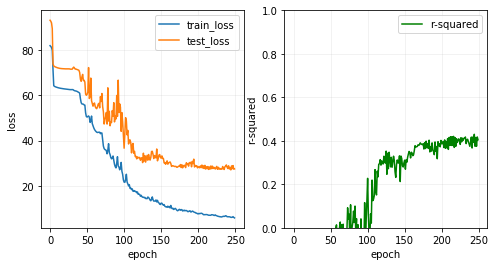

fold 6 held out
train_loss: 5.4821
test_loss: 26.3778
r-squared: 0.4871


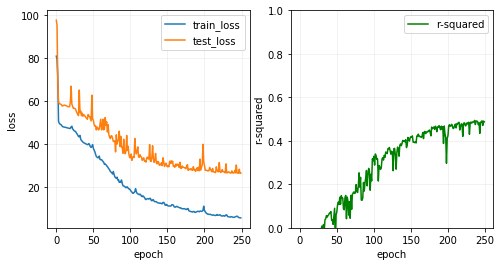

fold 7 held out
train_loss: 5.9592
test_loss: 22.3008
r-squared: 0.0724


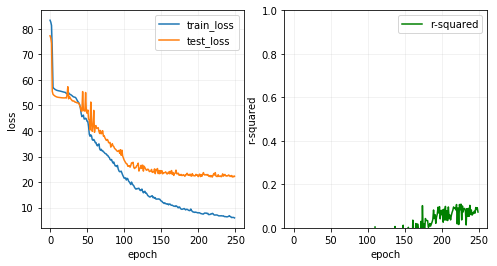

fold 8 held out
train_loss: 5.6455
test_loss: 25.4606
r-squared: 0.3581


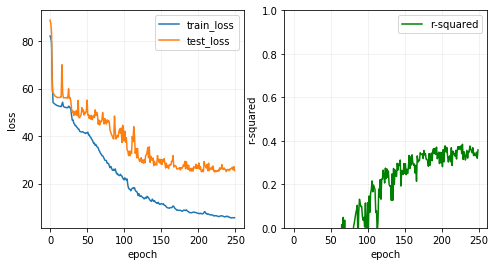

fold 9 held out
train_loss: 5.8576
test_loss: 30.4496
r-squared: 0.4603


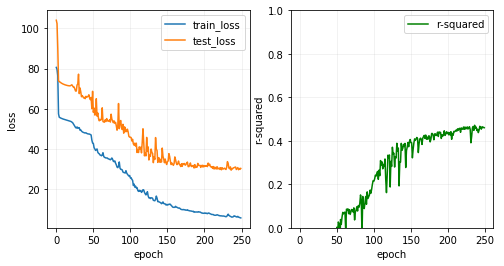

fold 10 held out
train_loss: 6.0344
test_loss: 21.9844
r-squared: 0.5206


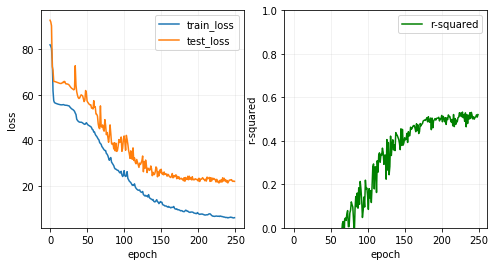

finished training. 

n_hidden: 600 size: 4 

fold 1 held out
train_loss: 6.113
test_loss: 21.6673
r-squared: 0.4731


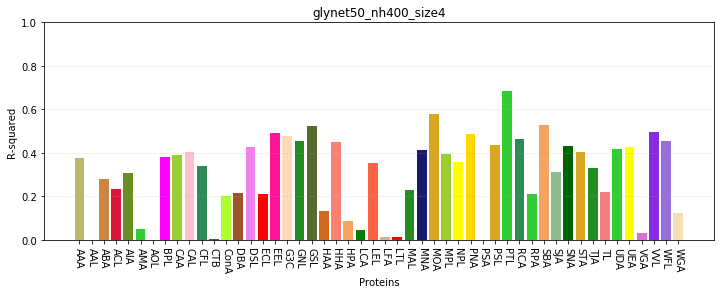

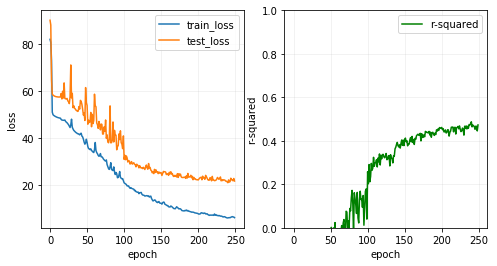

fold 2 held out
train_loss: 5.4818
test_loss: 26.4657
r-squared: 0.3384


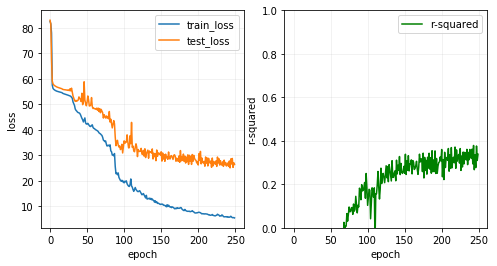

fold 3 held out
train_loss: 6.1638
test_loss: 23.9576
r-squared: 0.4631


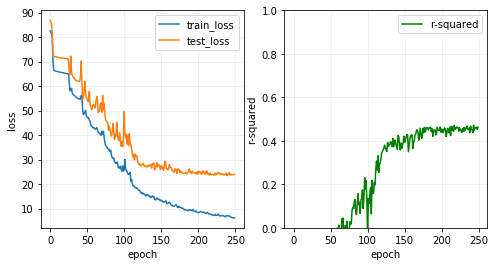

fold 4 held out
train_loss: 5.1724
test_loss: 23.7474
r-squared: 0.3005


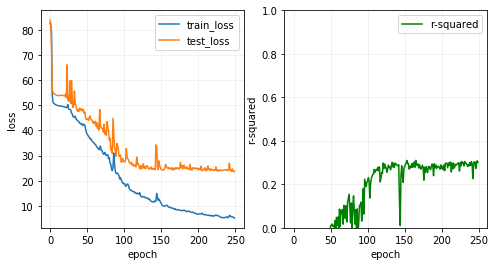

fold 5 held out
train_loss: 5.6366
test_loss: 27.1949
r-squared: 0.4166


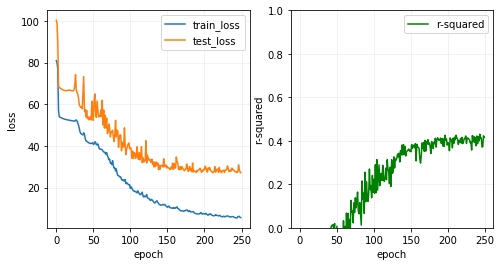

fold 6 held out
train_loss: 5.2761
test_loss: 26.6622
r-squared: 0.2909


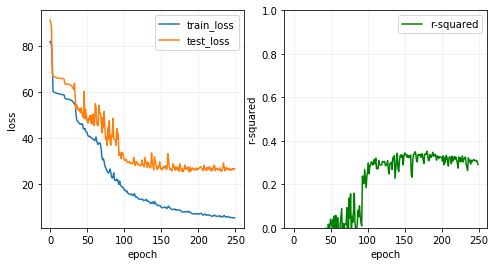

fold 7 held out
train_loss: 5.7807
test_loss: 24.9364
r-squared: 0.3962


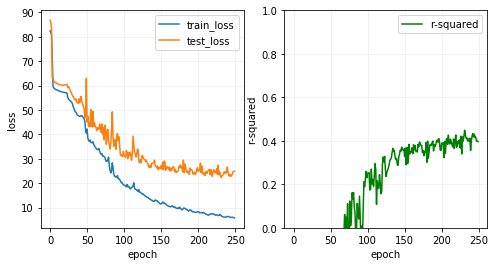

fold 8 held out
train_loss: 5.2012
test_loss: 22.9595
r-squared: 0.4176


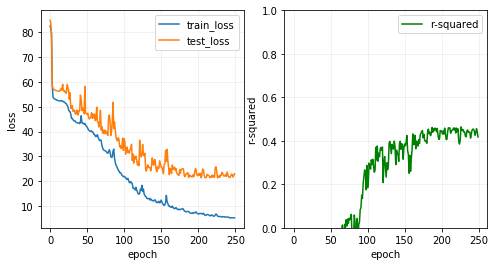

fold 9 held out
train_loss: 5.5318
test_loss: 26.4745
r-squared: 0.4423


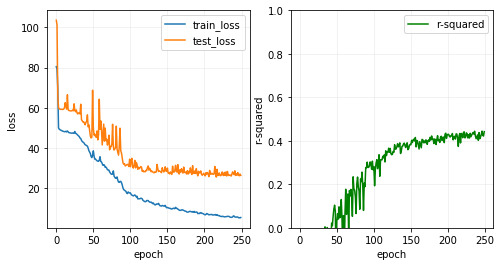

fold 10 held out
train_loss: 6.3348
test_loss: 26.9772
r-squared: 0.4281


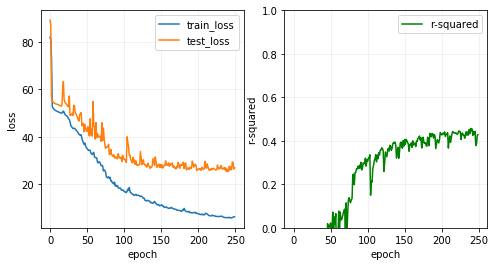

finished training. 

n_hidden: 1200 size: 4 

fold 1 held out
train_loss: 5.4031
test_loss: 26.9316
r-squared: 0.336


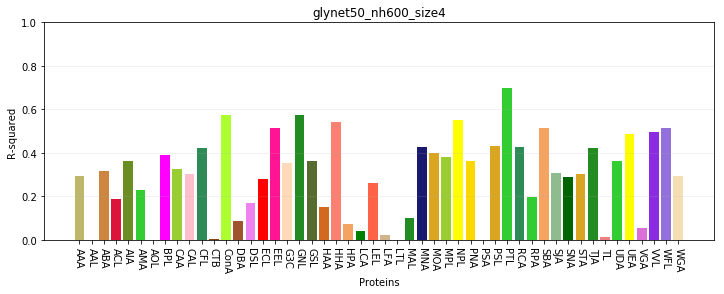

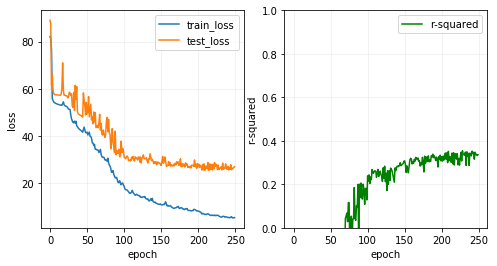

fold 2 held out
train_loss: 5.4584
test_loss: 24.9264
r-squared: 0.5782


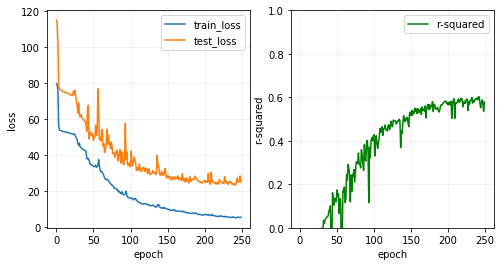

fold 3 held out
train_loss: 4.9966
test_loss: 26.6915
r-squared: 0.4393


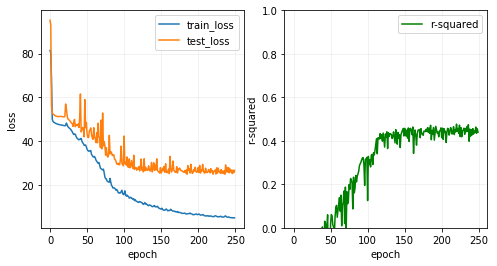

fold 4 held out
train_loss: 5.4845
test_loss: 25.2101
r-squared: 0.4703


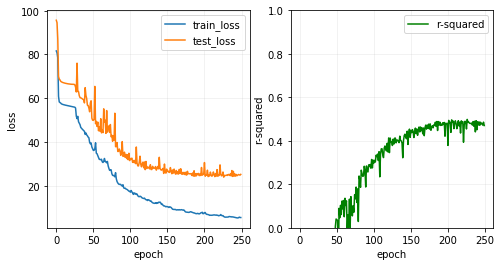

fold 5 held out
train_loss: 4.9133
test_loss: 22.4373
r-squared: 0.402


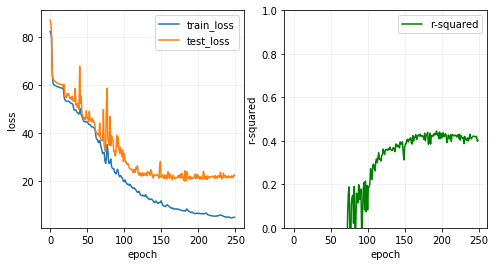

fold 6 held out
train_loss: 5.6894
test_loss: 24.6815
r-squared: 0.3808


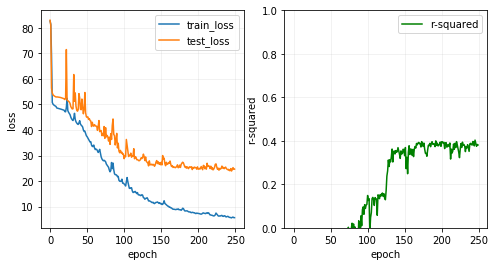

fold 7 held out
train_loss: 5.2107
test_loss: 19.6896
r-squared: 0.5145


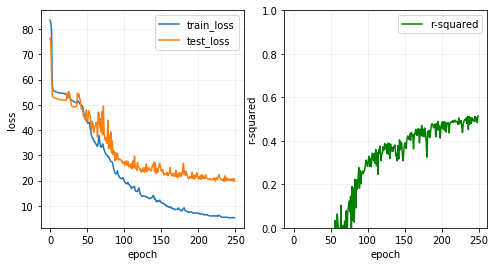

fold 8 held out
train_loss: 6.2529
test_loss: 22.5445
r-squared: 0.3834


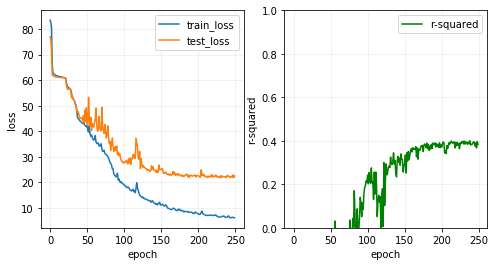

fold 9 held out
train_loss: 5.2669
test_loss: 26.0422
r-squared: 0.3954


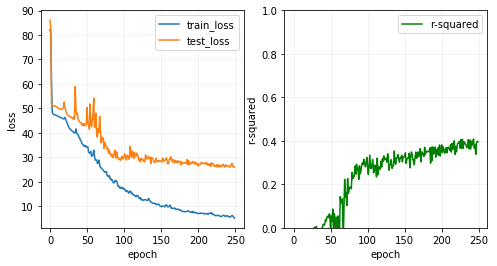

fold 10 held out
train_loss: 5.4876
test_loss: 28.0699
r-squared: 0.3863


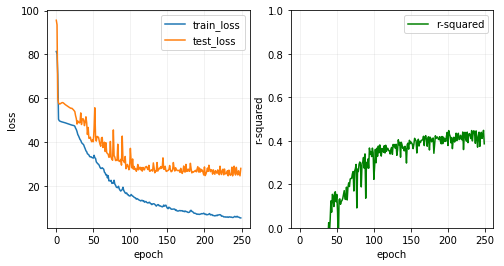

finished training. 



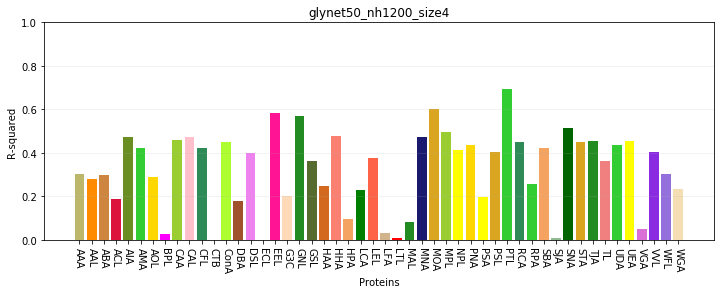

In [7]:
size = 4
for n_hidden in [200, 400, 600, 1200]:
    print('n_hidden:', n_hidden, 'size:', size, '\n')
    train(epochs, lr, batch_size, n_hidden, size)

In [8]:
# for protein in proteins:
#     results = results.sort_values(protein + ' actual')
#     plot_results(results[protein + ' actual'].values, results[protein + ' predicted'].values,
#                  title = protein + '_' + experiment, color = color_dict[protein])